In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Identification Using PyTorch**

Preprocess and divide the data into pixels and labels.


In [ ]:
class SignLanguageDataset(Dataset):
    """Sign Language dataset."""

    def __init__(self, train = True, transform = None):
        
        self.train = train
        self.transform = transform
        
        if self.train == True:
            self.signs = pd.read_csv('./drive/My Drive/sign-language-mnist/sign_mnist_train.csv')
        else:
            self.signs = pd.read_csv('./drive/My Drive/sign-language-mnist/sign_mnist_test.csv')
            
        self.images = self.signs.iloc[:, 1:].values
        self.labels = self.signs.iloc[:, 0].values
        
        self.images = np.reshape(self.images, (self.images.shape[0], 1, 28, 28)) / 255
        self.labels = np.array(self.labels)
            
        
    def __getitem__(self, index):
        
        image = self.images[index, :, :]
        
        label = self.labels[index]
        
        sample = {'image': image, 'label': label}
        
        return sample
        
    def __len__(self):
        return self.images.__len__()

Define the convolutional neural network. It has five layers. The network passes through 4 convolutional layers which allow the network to capture more high-level features and gain a better understanding of the image. We max pool at the end of the first two convolutions, which help to reduce noise as well as computation power required and extract more dominant features. Additionally, each convolution layer applies batch normalization to help normalize the data and increase computation speed while also reducing generalization error. Finally the image is passed through two linearizers to allow the data to be classified to one of 24 different outputs. 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 200, kernel_size = 5)
        self.batch_norm1 = nn.BatchNorm2d(200)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv2 = nn.Conv2d(200, 150, kernel_size = 5)
        self.batch_norm2 = nn.BatchNorm2d(150)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        
        self.conv3 = nn.Conv2d(150, 100, kernel_size = 1)
        self.batch_norm3 = nn.BatchNorm2d(100)
        
        self.conv4 = nn.Conv2d(100, 80, kernel_size = 1)
        self.batch_norm4 = nn.BatchNorm2d(80)
        
        self.fc1 = nn.Linear(1280, 250)
        self.fc2 = nn.Linear(250, 25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x

Initialize the network and its hyperparameters. 

In [ ]:
torch.manual_seed(71399)
device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
learning_rate = 0.002
num_epochs = 5
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.003)

Define the training and testing functions, using a zero gradient optimizer and outputting the accuracy.

In [ ]:
def train(model, optimizer, epoch, device, train_loader):
    result = []
    model.train()
    for idx, data in enumerate(train_loader):
        
        image = data['image'].type(torch.FloatTensor).to(device)
        label = data['label'].type(torch.LongTensor).to(device)
    
        optimizer.zero_grad()
        output = model(image)

        loss = F.nll_loss(output, label)
        
        loss.backward()
        optimizer.step()
        
        if idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(train_loader.dataset), 
                100. * idx / len(train_loader), loss.item()))
    result.append(loss.item())
    return result


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            
            image = data['image'].type(torch.FloatTensor).to(device)
            label = data['label'].type(torch.LongTensor).to(device)
            
            output = model(image)
            test_loss += F.nll_loss(output, label, size_average=False).item() 
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

Prepare the testing and training set 

In [ ]:
batch_size_train = 4
batch_size_test = 4
dataset_train = SignLanguageDataset(train = True)
dataset_test = SignLanguageDataset(train = False)
train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size_train)
test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size_test)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_result(loss_log):
  plt.figure(figsize=(10,9))
  x_axis = [] 
  for i in range(1, num_epochs+1):
    x_axis.append(i)
  plt.plot(x_axis, loss_log)
  plt.show()
  # plt.plot(np.ones(len(acc_log)), linestyle='dashed')

Run the neural network for 5 epochs.

In [ ]:
trl = []
acc = [] 
for epoch in range(1, num_epochs + 1):
    result = train(model, optimizer, epoch, device, train_loader)
    trl.append(result)
    accuracy = test(model, device, test_loader)
    acc.append(accuracy)
plot_result(trl)
plot_result(acc)

Train Epoch: 1 [0/27455 (0%)]	Loss: 3.236501
Train Epoch: 1 [4000/27455 (15%)]	Loss: 0.468095
Train Epoch: 1 [8000/27455 (29%)]	Loss: 0.170471
Train Epoch: 1 [12000/27455 (44%)]	Loss: 0.064487
Train Epoch: 1 [16000/27455 (58%)]	Loss: 0.053596


KeyboardInterrupt: ignored

Output accuracies for individual letters

In [ ]:
class_correct = list(0. for i in range(25))
class_total = list(0. for i in range(25))
with torch.no_grad():
    for data in test_loader:
        images = data['image']
        images = images.type(torch.FloatTensor).to(device)
        label = data['label']
        label = label.type(torch.LongTensor).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == label).squeeze()
        for i in range(len(label)):
            idx = label[i]
            class_correct[idx] += c[i].item()
            class_total[idx] += 1

signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', 
         '6': 'G', '7': 'H', '8': 'I', '10': 'K', '11': 'L', '12': 'M', 
         '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S', 
         '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
for i in range(24):
    if (class_total[i] == 0): class_total[i] = 1;
    print(signs.get(str(i)))
    print(100 * class_correct[i] / class_total[i])

Define function to output prediction given a preprocessed image

In [ ]:
def predict(image):
    images = image.type(torch.FloatTensor).to(device)
    output = model(images)
    print(output)
    _, predicted = torch.max(output, 1)
    print(predicted)
    
    signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', 
         '6': 'G', '7': 'H', '8': 'I', '10': 'K', '11': 'L', '12': 'M', 
         '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S', 
         '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
    
    softmax = torch.exp(output).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)
    print(signs.get(str(predictions[0])))

We use the Python Imaging Library (PIL) to process images.

In [ ]:
from PIL import Image, ImageOps
import seaborn as sns

Attempt One to preprocess

In [ ]:
image_path = './drive/My Drive/sign-language-mnist/sign_mnist_test/L.png'
l2 = './drive/My Drive/sign-language-mnist/sign_mnist_test/L2.png'

l2 = Image.open(l2).convert('L')
im = Image.open(image_path).convert('L')
width = float(im.size[0])
height = float(im.size[1])

img = np.array(ImageOps.fit(im, (28,28), Image.ANTIALIAS))
img2 = np.array(ImageOps.fit(l2, (28,28), Image.ANTIALIAS))
              
plt.imshow(img2, interpolation = 'nearest', cmap='Greys_r')
plt.show()
test_x = np.array(img2)
test_x = img2.reshape(1, 1, 28, 28)

plt.figure(figsize=(10,8))
plt.subplot(221)
sns.heatmap(data=img2)

test_x  = torch.from_numpy(test_x)

predict(test_x)

Attempt two to preprocess

In [ ]:
import cv2 
def image_predict(image_path)
  df = pd.DataFrame()
  img = cv2.imread(image_path, 0)
  re = cv2.resize(img, (28, 28))
  arr = np.asarray(re).ravel()
  df = df.append([arr], ignore_index=True)
  df = df.values.reshape(1, 1, 28, 28)
  df = df.astype('float32')
  df /= 255
  test_x  = torch.from_numpy(df)

  predict(test_x)

Attempt three by trying to manually resize

In [ ]:
image_path = '/kaggle/input/sign-language-a-v2/asign.png'
im = Image.open(image_path).convert('L')
width = float(im.size[0])
height = float(im.size[1])
newImage = Image.new('L', (28,28), (255))
​
if width > height:
    nheight = int(round((20.0/width*height), 0)) #1
    if(nheight == 0) :
        nheight = 1
    img = img.resize((20,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN) #1
    wtop = int(round(((28-nheight)/2), 0))
    newImage.paste(img, (4,wtop))
else:
    nwidth = int(round((25.0/height*width), 0)) #1
    if(nwidth == 0):
        nwidth = 1
    img = im.resize((nwidth, 25), Image.ANTIALIAS).filter(ImageFilter.SHARPEN) #1
    wleft = int(round(((28-nwidth)/2), 0))
    newImage.paste(img, (wleft, 4))
​
tv = list(newImage.getdata())
tva = [(255-x) *1.0 / 255.0 for x in tv]

​
newArr = [[0 for d in range(28)] for y in range(28)]
k = 0
for i in range(28):
    for j in range(28):
        newArr[i][j] = tva[k]
        k = k+1
              
plt.imshow(newArr, interpolation = 'nearest', cmap='Greys_r')
plt.show()
test_x = np.array(newArr)
test_x = test_x.reshape(1, 1, 28, 28)
test_x  = torch.from_numpy(test_x)
predict(test_x)

SyntaxError: ignored

# **Identification Using TensorFlow**

Imports:

In [ ]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE

**Process Data**

In [ ]:
train = pd.read_csv('./drive/My Drive/sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('./drive/My Drive/sign-language-mnist/sign_mnist_test.csv')

In [ ]:
#Training Data
train_labels = train['label'].values
train.drop('label', axis = 1, inplace = True)
train_images = train.values
train_images = np.array([np.reshape(i, (28, 28)) for i in train_images])

#Testing Data
test_labels = test['label'].values
test.drop('label', axis = 1, inplace = True)
test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])

#Normalizing images
train_images = train_images / 255.0
test_images = test_images / 255.0

#Defining Class Names 
class_names = ['a', 'b', 'c', 'd', 'e',
               'f', 'g', 'h', 'i','j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't','u','v','w',
              'x', 'y']

Sample of 25 images from dataset, with their respective classifications

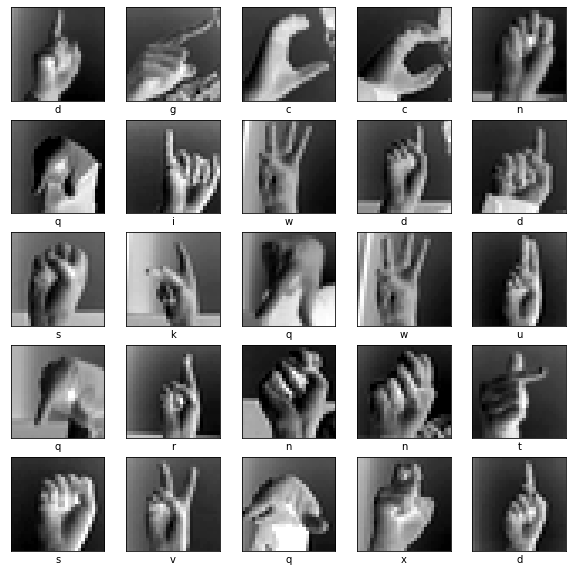

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

**Neural Network Model**

Layers:

1.   Converts images from (28x28) array into one dimensional array of 784 pixels.
2.   Fully connected neural layer with 128 nodes.
3.   Consists of 25 nodes which return an array of 25 probability scores summing to 1 that indicate the probability of an image belonging to that class.

Model Settings:
*   Optimizer controls how model is updated based on the data and loss function.
*  Loss function measures accuracy during training.
* Metrics moniters training and testing steps with accuracy representing the fraction of images that are correctly classified.


In [ ]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(25, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=1)

Train on 27455 samples
27455/27455 [==============================] - 2s 81us/sample - loss: 2.5583 - acc: 0.2343


**Evaluation**

Model above reached accuracy of around 80% on the training data.

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

7172/7172 - 0s - loss: 2.0284 - acc: 0.3783

Test accuracy: 0.37827665


The accuracy on the test data was slightly less, around 71%. This indicates *overfitting* which occurs when a model does not perform as well on data that it has not yet seen compared to the training set.

**Example Predictions**

In [ ]:
predictions = model.predict(test_images)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(25))
  plt.yticks([])
  thisplot = plt.bar(range(25), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

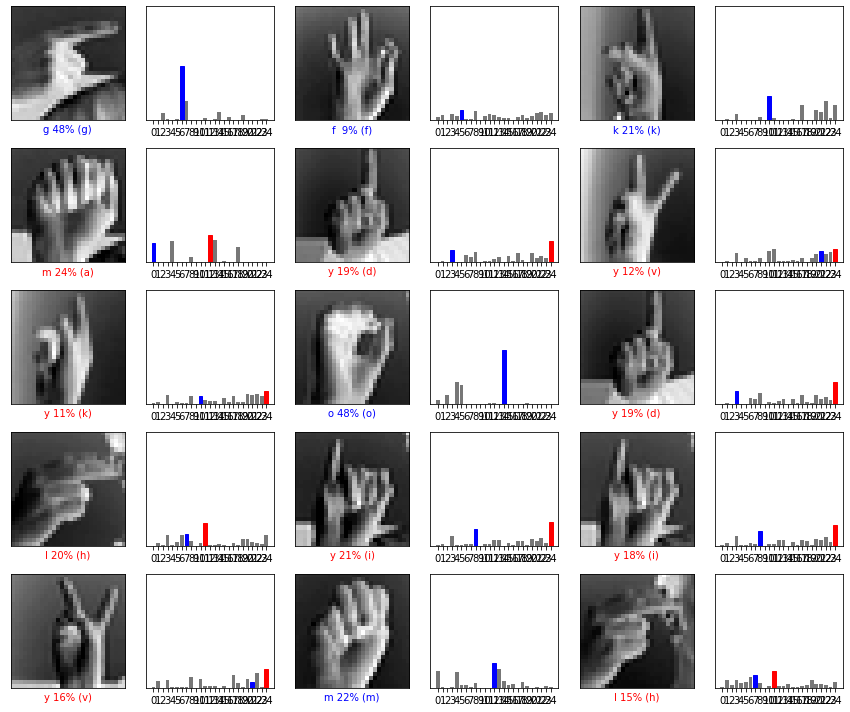

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Use model to make a prediction about a single image. 

(28, 28)
(1, 28, 28)


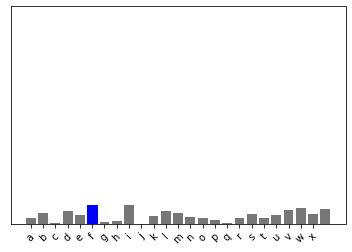

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

# Add the image to a batch where it's the only member.
print (img.shape)
img = (np.expand_dims(img,0))
print(img.shape)

predictions_single = model.predict(img)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)

In [ ]:
#upload images
imageL_path = './drive/My Drive/L.jpg'
imageW_path = './drive/My Drive/W.jpg'
imageA_path = './drive/My Drive/W.jpg'

imageLw_path = './drive/My Drive/IMG_5240.JPG'
imageWw_path = './drive/My Drive/IMG_5243.JPG'
imageAw_path = './drive/My Drive/IMG_5244.JPG'

imgL = Image.open(imageL_path)
imgW = Image.open(imageW_path)
imgA = Image.open(imageA_path)
imgLw = Image.open(imageLw_path)
imgWw = Image.open(imageWw_path)
imgAw = Image.open(imageAw_path)

In [ ]:
def NN_reshape(img):
  img = img.convert('L')
  img_shaped = np.array(img.resize((28, 28), Image.ANTIALIAS))
  img_shaped.reshape(28,28)
  img_shaped = img_shaped/255
  img_shaped = np.expand_dims(img_shaped,0)
  #print (img_shaped)
  return (img_shaped)


In [ ]:
single_L = NN_reshape(imgL)
single_W = NN_reshape(imgW)
single_A = NN_reshape(imgA)
single_Lw = NN_reshape(imgLw)
single_Ww = NN_reshape(imgWw)
single_Aw = NN_reshape(imgAw)


In [ ]:
predictions_L = model.predict(single_L)
predictions_W = model.predict(single_W)
predictions_A = model.predict(single_A)
predictions_Lw = model.predict(single_Lw)
predictions_Ww = model.predict(single_Ww)
predictions_Aw = model.predict(single_Aw)


L


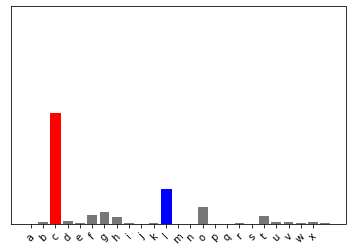

In [ ]:
print ("L")
plot_value_array(0, predictions_L[0], [11])
_ = plt.xticks(range(24), class_names, rotation=45)


W


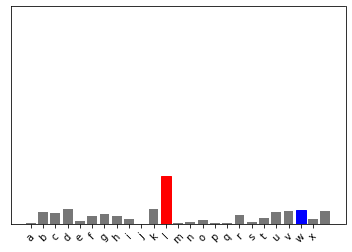

In [ ]:
print ("W")
plot_value_array(0, predictions_W[0], [22])
_ = plt.xticks(range(24), class_names, rotation=45)

A


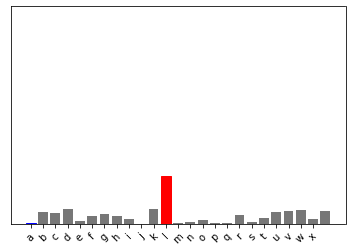

In [ ]:
print ("A")
plot_value_array(0, predictions_A[0], [0])
_ = plt.xticks(range(24), class_names, rotation=45)

Lw


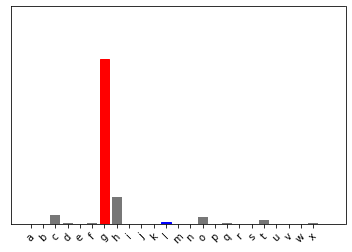

In [ ]:
print ("Lw")
plot_value_array(0, predictions_Lw[0], [11])
_ = plt.xticks(range(24), class_names, rotation=45)

Ww


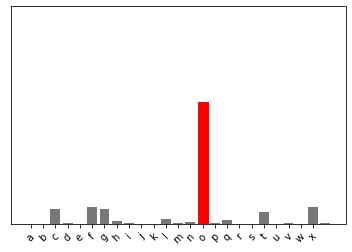

In [ ]:
print ("Ww")
plot_value_array(0, predictions_Ww[0], [22])
_ = plt.xticks(range(24), class_names, rotation=45)

Aw


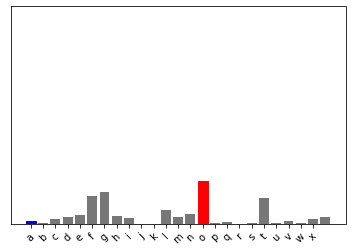

In [ ]:
print ("Aw")
plot_value_array(0, predictions_Aw[0], [0])
_ = plt.xticks(range(24), class_names, rotation=45)

**Convolutional Neural Networks**


Convolutional Base:

6 layers of Conv2d and MaxPooling2D layers.

Inputs:


*   Input shape includes (image_height, image_width, color range)
*   The activation function used is Rectified Linear Unit (relu),  defined by f(x) = max(0,x), which is used due to its simplicity which makes it computationally fast and has fewer vanishing gradients. 




In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

Feed output into dense layers for classification. 25 outputs for our class labels and a softmax activation (a generalized logistic regression for multiple classes) 

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(25, activation='softmax'))

train_images_new = train_images.reshape(-1,28, 28, 1)   #Reshape for CNN 
test_images_new = test_images.reshape(-1,28, 28, 1)

Compile and train model. 

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images_new, train_labels, epochs=1, 
                    validation_data=(test_images_new, test_labels))

Train on 27455 samples, validate on 7172 samples
27455/27455 [==============================] - 23s 830us/sample - loss: 0.2281 - acc: 0.9298 - val_loss: 0.4483 - val_acc: 0.8604


**Evaluation**

7172/7172 - 1s - loss: 0.7438 - acc: 0.7425


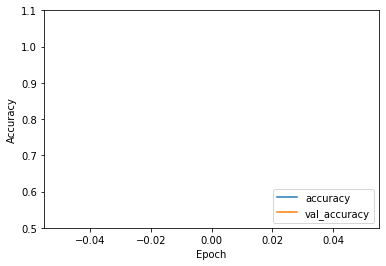

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_new,  test_labels, verbose=2)

In [ ]:
print(test_acc)

0.74247074




*   Accuracy: accuracy on batch of training data. 
*   Val Accuracy: accuracy on the validation set- i.e. the set that had not yet been seen by the model. 



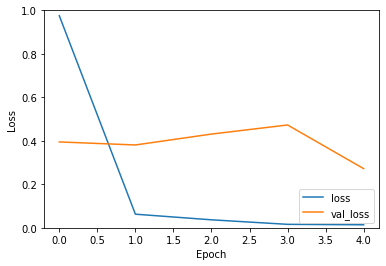

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
predictions = model.predict(test_images_new)

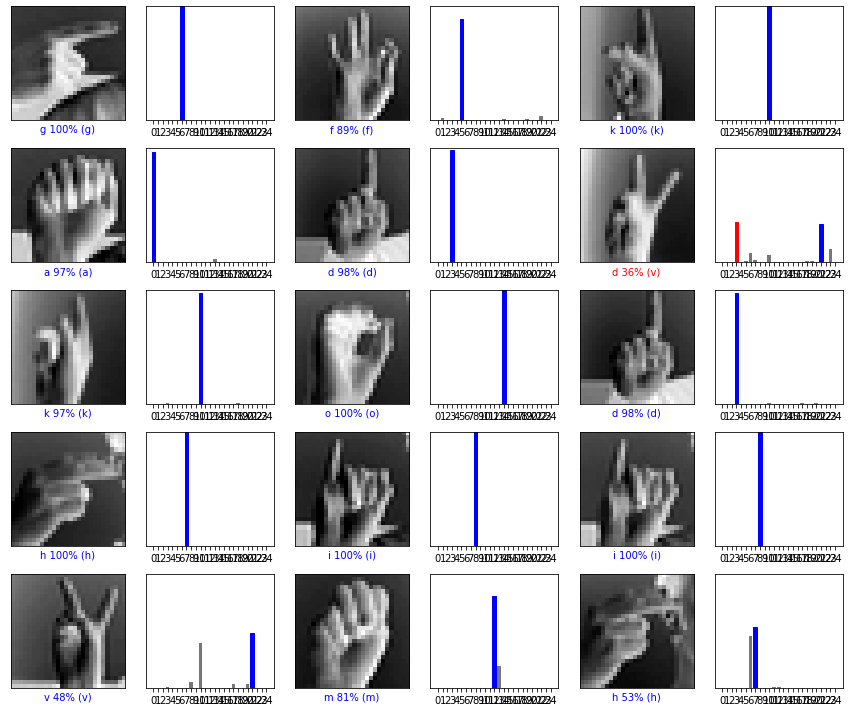

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# **CNN Evaluation Against Practical Images**

In [ ]:
def CNN_reshape(img):
  img = img.convert('L')
  img_28x28 = np.array(img.resize((28, 28), Image.ANTIALIAS))
  test = img_28x28.reshape(-1,28, 28, 1)
  test = test/255
  return test



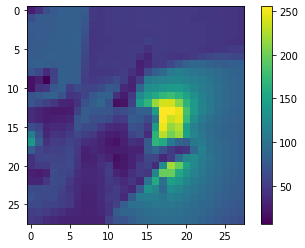

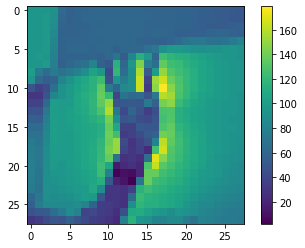

In [ ]:
plt.figure()
plt.imshow(img_28x28)
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.imshow(img2_28x28)
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
single_L = CNN_reshape(imgL)
single_W = CNN_reshape(imgW)
single_A = CNN_reshape(imgA)
single_Lw = CNN_reshape(imgLw)
single_Ww = CNN_reshape(imgWw)
single_Aw = CNN_reshape(imgAw)

In [ ]:
predictions_L = model.predict(single_L)
predictions_W = model.predict(single_W)
predictions_A = model.predict(single_A)
predictions_Lw = model.predict(single_Lw)
predictions_Ww = model.predict(single_Ww)
predictions_Aw = model.predict(single_Aw)

L


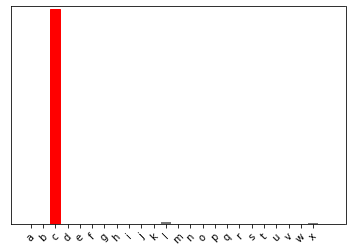

In [ ]:
print ("L")
plot_value_array(1, predictions_L[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)


W


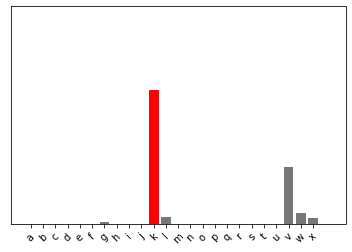

In [ ]:
print ("W")
plot_value_array(1, predictions_W[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)

A


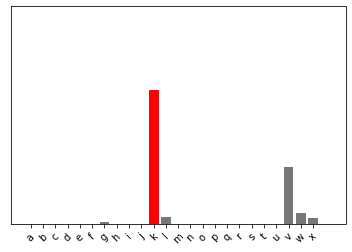

In [ ]:
print ("A")
plot_value_array(1, predictions_A[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)

Lw


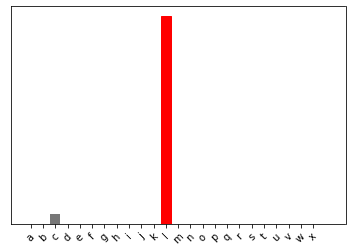

In [ ]:
print ("Lw")
plot_value_array(1, predictions_Lw[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)

Ww


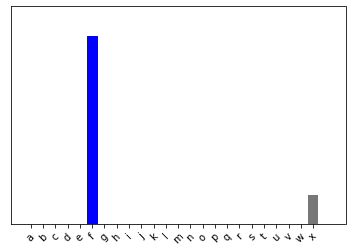

In [ ]:
print ("Ww")
plot_value_array(1, predictions_Ww[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)

Aw


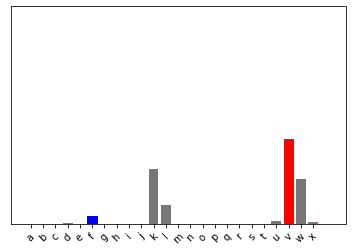

In [ ]:
print ("Aw")
plot_value_array(1, predictions_W[0], test_labels)
_ = plt.xticks(range(24), class_names, rotation=45)

# **"NLP"**

In [ ]:
words = open("./drive/My Drive/words_alpha.txt").read().split()
wordcost = dict((k, math.log((i+1)*math.log(len(words)))) for i,k in enumerate(words))
maxlength = max(len(x) for x in words)

In [ ]:
def add_space(s):
  def recurrence(i):
        costs = reversed(opt[max(0, i-maxlength):i])
        candidates = enumerate(costs)
        best_cost_length = min((c + wordcost.get(s[i-l-1:i], 9e999), l+1) for l,c in candidates)
        return best_cost_length 
  
  opt = [0]
  for i in range(1,len(s)+1):
      c,l = recurrence(i)
      opt.append(c)

  result = []
  i = len(s)
  while i>0:
      c,l = recurrence(i)
      result.append(s[i-l:i])
      i = i-l 
  
  return " ".join(reversed(result))

In [ ]:
s = 'hellotherehowareyou'
print(add_space(s))

hello there how are you


In [ ]:
trl = trial(opt)
  for i in trl[0]:
    print('Epoch: {} - Loss: {}'.format(i[0],i[1]))
  plot_result(trl[1][0], trl[1][1])
  predict()

In [ ]:
def trial (optimizer,loss_log = [],acc_log = []):
  result = []
  for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
      x_min_i = x[i:i + batch_size] # Tensor with shape [55, 1, 28, 28]
      y_min_i = y[i:i + batch_size] # Tensor with shape [55]

      optimizer.zero_grad()
      net_out = net(Variable(x_min_i))

      loss = loss_func(net_out, Variable(y_min_i))
      loss.backward()
      optimizer.step()

      if i % 1000 == 0:
        # pred = net(Variable(test_data_tfm))
        loss_log.append(loss.item())
        acc_log.append(
            net.evaluate(
                torch.max
                (
                    net(Variable(test_data_tfm[:600])).data, 1) #Tensor with shape [7172, 1, 28, 28]
                [1],
                test_labels[:600]
              )
            )
    result.append((e+1,loss.item()))
    # print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))
  return result,(loss_log,acc_log) 
  #returns a triplet containing
  #results of Loss at each Epoch,
  #the loss log
  #the accuracy log